In [1]:
%matplotlib inline
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.lines import Line2D

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from netCDF4 import Dataset as netcdf_dataset

import shapefile as shp

from obspy.geodetics import kilometers2degrees

# Creating maps in Cartopy

In this notebook we will learn how to create maps using [*Cartopy*](https://scitools.org.uk/cartopy/) package for Python.

The package uses stadard Matplotlib engine to generate the plots, which makes it very easy to personalise them.

## Map projections in Cartopy

Full list of projections is available at https://scitools.org.uk/cartopy/docs/latest/crs/projections.html.

**Useful map projections:**
- Equirectangular projection - conserves distances along meridians, plate carrée projection uses equator as a standard parallel.
  
- Mercator projection - preserves angles and shapes of small objects, but inflates areas away from equator.

- Equidistant conic projection - useful for East-West elongated countries.

- Azimuthal equidistant projection - useful for polar regions.

- Equal Earth projection - equal area and pseudocylindrical projection.

- Robinson - whole Earth projection, it is neither equal-area nor conformal.



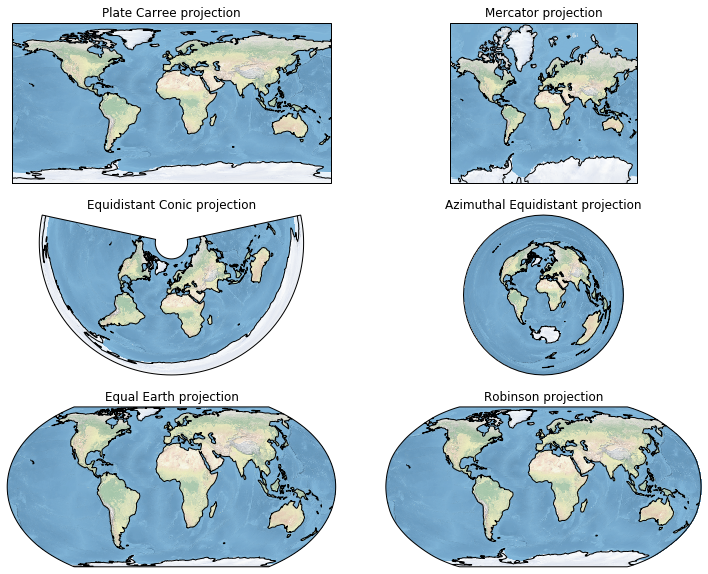

In [2]:
plt.figure(figsize=(20,10))

# List of map projections and their names

projections = [ccrs.PlateCarree(), ccrs.Mercator(), ccrs.EquidistantConic(),
               ccrs.AzimuthalEquidistant(), ccrs.EqualEarth(), ccrs.Robinson()]

projection_names = ["Plate Carree", "Mercator", "Equidistant Conic",
                    "Azimuthal Equidistant", "Equal Earth", "Robinson"]

# Loop over projections to create 6 subplots in 3 rows and 2 columns

for i in range(len(projections)):
    
    ax = plt.subplot(3, 2, i+1, projection=projections[i])
    ax.set_title(projection_names[i] + " projection")
    
    ax.set_global()
        
    # Add coastlines at 110 m resolution, can be changed to 10 and 50 m
    ax.coastlines('110m', lw=1)
    
    # Add Natural Earth relief raster
    ax.stock_img()

plt.subplots_adjust(wspace=-0.5)
plt.show()

Map of Antartica can be created using SouthPolarStereo(), which is an azimuthal equidistant projection. In the previous example, we were using Natural Earth relief image for each map. In this example, we are using *ax.add_features()* that allows to customise features such as ocean, land, rivers, lakes and country borders.

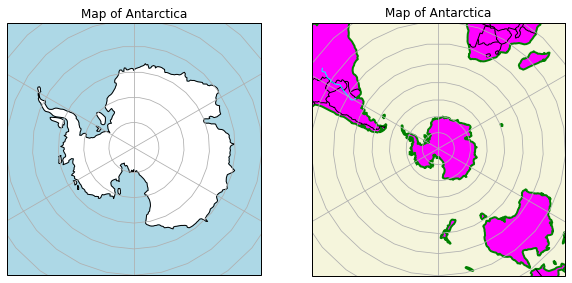

In [3]:
fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(1,2,1, projection=ccrs.SouthPolarStereo())
ax2 = fig.add_subplot(1,2,2, projection=ccrs.SouthPolarStereo())

ax1.coastlines("110m")
ax1.gridlines()
ax1.set_title("Map of Antarctica")
ax1.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())

# Add features
ax1.add_feature(cfeature.LAND, color="white")
ax1.add_feature(cfeature.OCEAN, color="lightblue")


ax2.coastlines("110m", lw=2, color="green")
ax2.gridlines()
ax2.set_title("Map of Antarctica")
ax2.set_extent([-180, 180, -90, -20], ccrs.PlateCarree())

# Add features
ax2.add_feature(cfeature.LAND, color="magenta")
ax2.add_feature(cfeature.OCEAN, color="beige")
ax2.add_feature(cfeature.BORDERS, edgecolor="black")
ax2.add_feature(cfeature.RIVERS, edgecolor="cyan", lw=1)

plt.show()

## Plotting data with Cartopy

### Scatter plots

First, we will generate a grid of points and assign them some values that will be used as colours:

In [4]:
# Generate a grid of points
x = np.linspace(-9,0,10)
y = np.linspace(51, 58, 10)

X, Y = np.meshgrid(x,y)

# Generate colour values
Z = np.sqrt(X**2 + Y**2)

We can plot the data using *scatter()* class:

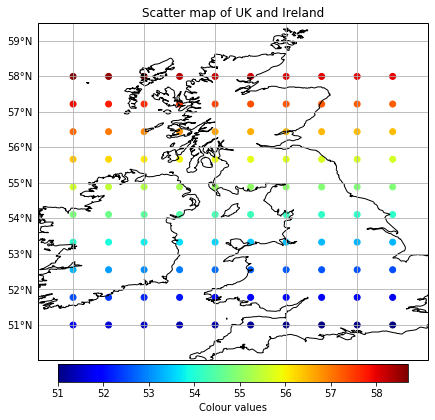

In [5]:
fig, ax = plt.subplots(1, subplot_kw=dict(projection=ccrs.PlateCarree()), figsize=(7,7))

ax.set_extent([-10, 1, 50, 59.5])
ax.coastlines(resolution='10m')
ax.set_title("Scatter map of UK and Ireland")

# Create a scatter plot
scatplot = ax.scatter(X, Y, c=Z, cmap="jet", transform=ccrs.PlateCarree())

# Create colourbar
cbar = plt.colorbar(scatplot, ax=ax, fraction=0.046, pad=0.01, label='Colour values',
                   orientation="horizontal")

# Sort out gridlines and their density
xticks_extent = list(np.arange(-11, 2, 2))
yticks_extent = list(np.arange(49, 64, 1))

gl = ax.gridlines(linewidths=0.1)
gl.xlabels_top = False
gl.xlabels_bottom = True
gl.ylabels_left = True
gl.ylabels_right = False
gl.xlocator = mticker.FixedLocator(xticks_extent)
gl.ylocator = mticker.FixedLocator(yticks_extent)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

plt.show()

### Contour plots
**Bathymetry example with .nc files**

This type of data can be plotted with matplotlib contourf() function. To make sure your data is plotted in a correct projection, you need to add an extra argument in the function:

    transform = ccrs.PlateCarree()
    
if using ccrs.PlateCaree() projection. If using the Mercator projection, add:

    transform = ccrs.Geodetic()

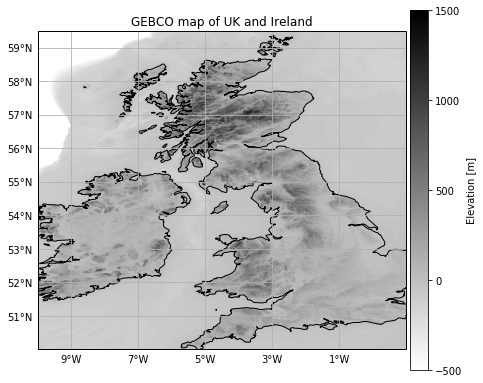

In [6]:
# Load GEBCO data downloaded from https://download.gebco.net/
fname = "data/gebco_uk_ireland.nc"

dataset = netcdf_dataset(fname)

# Load data into separate arrays, if variables are not known, print(dataset.variables) to check them
elev = dataset.variables['elevation'][:]
lats = dataset.variables['lat'][:]
lons = dataset.variables['lon'][:]

fig, ax = plt.subplots(1, subplot_kw=dict(projection=ccrs.PlateCarree()), figsize=(7,7))

ax.set_extent([-10, 1, 50, 59.5])
ax.coastlines(resolution='10m')
ax.set_title("GEBCO map of UK and Ireland")

# Set colourbar limits

vmin = -500
vmax = 1500

# Set how many contour lines to display
v = np.linspace(vmin, vmax, 100, endpoint=True)

# Set how many ticks to display in colourbar
v2 = np.linspace(vmin, vmax, 5, endpoint=True)

# Create a contour plot
contplot = ax.contourf(lons, lats, elev, v, cmap="binary", vmin=vmin, vmax=vmax,
                       transform=ccrs.PlateCarree())

cbar = plt.colorbar(contplot, ax=ax, fraction=0.046, pad=0.01, ticks=v2, label='Elevation [m]')


# Sort out gridlines and their density
xticks_extent = list(np.arange(-11, 2, 2))
yticks_extent = list(np.arange(49, 64, 1))

gl = ax.gridlines(linewidths=0.1)
gl.xlabels_top = False
gl.xlabels_bottom = True
gl.ylabels_left = True
gl.ylabels_right = False
gl.xlocator = mticker.FixedLocator(xticks_extent)
gl.ylocator = mticker.FixedLocator(yticks_extent)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

plt.show()

### Quiver plots

First generate a grid of points and vector components that will be plotted on the map:

In [7]:
# Generate a grid of points
x = np.linspace(-9,0,10)
y = np.linspace(51, 58, 10)

X, Y = np.meshgrid(x,y)

# Generate horizontal and vertical values of vector components
U = X * np.cos(X) - Y * np.cos(Y)
V = X * np.sin(X) - Y * np.sin(Y)

Cartopy only allows to create quiver plots for PlateCarree() or rotated pole projections. It does not work for Marcator projection. In this example, we will use the same projection as we used for bathymetry plots:

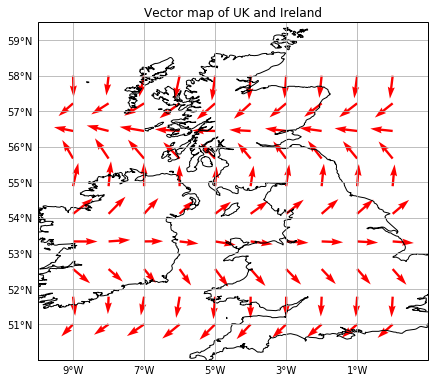

In [8]:
fig, ax = plt.subplots(1, subplot_kw=dict(projection=ccrs.PlateCarree()), figsize=(7,7))

ax.set_extent([-10, 1, 50, 59.5])
ax.coastlines(resolution='10m')
ax.set_title("Vector map of UK and Ireland")

# Create a quiver plot
ax.quiver(X, Y, U, V, transform=ccrs.PlateCarree(), color="red", angles="uv")

# Sort out gridlines and their density
xticks_extent = list(np.arange(-11, 2, 2))
yticks_extent = list(np.arange(49, 64, 1))

gl = ax.gridlines(linewidths=0.1)
gl.xlabels_top = False
gl.xlabels_bottom = True
gl.ylabels_left = True
gl.ylabels_right = False
gl.xlocator = mticker.FixedLocator(xticks_extent)
gl.ylocator = mticker.FixedLocator(yticks_extent)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

plt.show()

## Plotting shapefiles

**California plate boundaries**

California lies at a transform fault boundary between the Pacific and the North American plates. This boundary is characterised by predominant horizontal motion between the plates.

According to [HS3-NUVELl1A](https://www.unavco.org/software/geodetic-utilities/plate-motion-calculator/plate-motion-calculator.html) plate velocity model, the Pacific plate at (35$^\circ$N, 120$^\circ$W) moves at 46.13 mm/yr relative to stationary American plate (azimuth = 322.64$^\circ$). The northern and eastern components of the motion are at 36.77 mm/yr and -27.99 mm/yr, respectively.

In this example, we will visualise California state, and parts that lie within Pacific and American plates. We will also visually investigate how long could it theoretically take Los Angeles (33.9416$^\circ$N) to reach San Francisco latitude (37.7749$^\circ$N).

First, we downloaded California state boundary shapefile from https://data.ca.gov/dataset/ca-geographic-boundaries and tectonic plate boundaries from https://www.usgs.gov/media/files/plate-boundaries-kmz-file and edited the files to create North American and Pacific plate parts of the state.

The functions below will be used to plot shapefiles in cartopy:

In [9]:
# Shapefile plotting functions modified from:
# https://gis.stackexchange.com/questions/131716/plot-shapefile-with-matplotlib

def plotShapefiles(shapefile_name, ax, colour, cartopy="yes"):
    sf = shp.Reader(shapefile_name)
    for shape in sf.shapeRecords():
        for i in range(len(shape.shape.parts)):
            i_start = shape.shape.parts[i]
            if i==len(shape.shape.parts)-1:
                i_end = len(shape.shape.points)
            else:
                i_end = shape.shape.parts[i+1]
                
            x = [i[0] for i in shape.shape.points[i_start:i_end]]
            y = [i[1] for i in shape.shape.points[i_start:i_end]]
            
            # ax is a subplot
            
            if cartopy=="yes":
                ax.plot(x,y,color=colour,transform=ccrs.Geodetic(), lw=2,zorder=1)
            else:
                ax.plot(x,y,color=colour, lw=2,zorder=1)
            
# vnorth is northern component of plate velocity in mm/yr
# veast is eastern component of plate velocity in mm/yr
# time in given in years
            
def plotTranslatedShapefiles(shapefile_name, ax, colour, vnorth, veast, time ,cartopy="yes"):
    sf = shp.Reader(shapefile_name)
    for shape in sf.shapeRecords():
        for i in range(len(shape.shape.parts)):
            i_start = shape.shape.parts[i]
            if i==len(shape.shape.parts)-1:
                i_end = len(shape.shape.points)
            else:
                i_end = shape.shape.parts[i+1]
                
            # For each point in each shape, we translate it by great circle distance in degrees
            # time*veast/1e6 is in km, provided [time] = years, [veast] = mm/year
            
            x = [i[0] + kilometers2degrees(time*veast/1e6) for i in shape.shape.points[i_start:i_end]]
            y = [i[1] + kilometers2degrees(time*vnorth/1e6) for i in shape.shape.points[i_start:i_end]]

            # ax is a subplot
            
            if cartopy=="yes":
                ax.plot(x,y,color=colour,transform=ccrs.Geodetic(), lw=2,zorder=1)
            else:
                ax.plot(x,y,color=colour, lw=2,zorder=1)

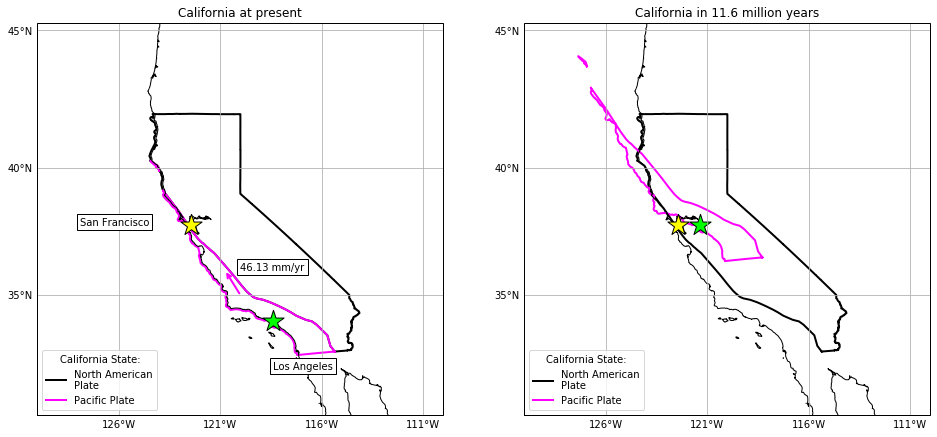

In [10]:
central_lon, central_lat = -120, 20

fig, (ax1, ax2) = plt.subplots(1,2, subplot_kw=dict(projection=ccrs.Mercator(central_lon, central_lat)),
                               figsize=(16,8))

# Set the same parameters so maps look the same

extent = [-130, -110, 30, 45]
xticks_extent = list(np.arange(-131,-100,5))
yticks_extent = list(np.arange(30,60,5))

for ax in (ax1, ax2):
    
    ax.set_extent(extent)
    ax.coastlines("10m")

    gl = ax.gridlines(linewidths=0.1)
    gl.xlabels_top = False
    gl.xlabels_bottom = True
    gl.ylabels_left = True
    gl.ylabels_right = False
    gl.xlocator = mticker.FixedLocator(xticks_extent)
    gl.ylocator = mticker.FixedLocator(yticks_extent)
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER


# Plot shapefiles

plotShapefiles("data/california_north_american_plate.shp", ax1, "black")
plotShapefiles("data/california_pacific_plate.shp", ax1, "magenta")

vnorth = 36.77 #mm/year
veast = -27.99 #mm/year
time = 11.6 * 1e6 #11.6 million years

plotShapefiles("data/california_north_american_plate.shp", ax2, "black")
plotTranslatedShapefiles("data/california_pacific_plate.shp", ax2, "magenta",
                         vnorth=vnorth, veast=veast, time=time)
    
# Plot Los Angeles and San Francisco on both maps
    
lat_sf = 37.7749
lon_sf = -122.4194

lat_la = 33.9416
lon_la = -118.4085

ax1.scatter(lon_sf, lat_sf, marker="*", c="yellow", s=500, edgecolor="black",
           zorder=2,transform=ccrs.Geodetic())
ax1.scatter(lon_la, lat_la, marker="*", c="lime", s=500, edgecolor="black",
           zorder=2,transform=ccrs.Geodetic())

ax2.scatter(lon_sf, lat_sf, marker="*", c="yellow", s=500, edgecolor="black",
           zorder=2,transform=ccrs.Geodetic())

ax2.scatter(lon_la+kilometers2degrees(time*veast/1e6), lat_la+kilometers2degrees(time*vnorth/1e6),
            marker="*", c="lime", s=500, edgecolor="black",
           zorder=2,transform=ccrs.Geodetic())

# Add text boxes

ax1.text(lon_sf-5.5, lat_sf, 'San Francisco', color='black', 
        bbox=dict(facecolor='white', edgecolor='black', pad=3.0),transform=ccrs.Geodetic(),zorder=2)

ax1.text(lon_la, lat_la-2, 'Los Angeles', color='black', 
        bbox=dict(facecolor='white', edgecolor='black', pad=3.0),transform=ccrs.Geodetic(),zorder=2)

# Plot velocity arrow

transform = ccrs.PlateCarree()._as_mpl_transform(ax1)
ax1.annotate("", xytext=(-120,35), xy=(-120+kilometers2degrees(veast)*3, 35+kilometers2degrees(vnorth)*3), 
            arrowprops=dict(arrowstyle="->", color="magenta", lw=2),xycoords=transform)

ax1.text(-120, 36, '46.13 mm/yr', color='black', 
        bbox=dict(facecolor='white', edgecolor='black', pad=3.0),transform=ccrs.Geodetic(),zorder=2)

# Create custom legend

legend_elements = [Line2D([0], [0], color='black', lw=2, label='North American\nPlate'),
                   Line2D([0], [0], color='magenta', lw=2, label='Pacific Plate')]

ax1.legend(handles=legend_elements, loc='lower left', title="California State:")
ax2.legend(handles=legend_elements, loc='lower left', title="California State:")

ax1.set_title("California at present")
ax2.set_title("California in %.1f million years" % (time/1e6))

        
plt.show()
